In [1]:
import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import Image, display
from dask.distributed import Client, progress
from datetime import datetime, timedelta
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker
import matplotlib.path as mpath
import matplotlib.patheffects as PathEffects
from scipy import stats
import scipy
import numpy.ma as ma
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib.colors as mcolors
import metpy.calc as mpcalc
from metpy.units import units
from scipy.ndimage import gaussian_filter
# %matplotlib inline

### Import GPM Data

In [2]:
def preprocess(ds):
    '''keep only the selected lats and lons'''
    return ds.sel(lat=slice(32,42), lon=slice(-125,-115))

filename_pattern =  '/home/sbarc/students/nash/data/GPM/imerg/3B*' 
ds = xr.open_mfdataset(filename_pattern, engine='netcdf4', concat_dim='time',
                       group='Grid', preprocess=preprocess)
print('ds size in GB {:0.2f}\n'.format(ds.nbytes / 1e9))
# ds.info()

precip = ds.precipitationCal.transpose('time', 'lat', 'lon')

ds size in GB 0.05



In [3]:
gpm_lats = precip.lat
gpm_lons = precip.lon
gpm_6hour = precip.resample(time='6H').mean('time')
gpm_6hour = gpm_6hour.load()

In [4]:
def preprocess(ds):
    '''keep only the selected lats and lons'''
    return ds.sel(latitude=slice(10,50), longitude=slice(210,250))

filename_pattern =  '/home/sbarc/students/nash/data/CFSv2/netcdf_CFSv2_vertical_levels/201*'
ds = xr.open_mfdataset(filename_pattern, engine='netcdf4', preprocess=preprocess)

da_SPFH = ds.spfh.sel(p=slice(1000,300))
da_V = ds.v.sel(p=slice(1000,300))
da_U = ds.u.sel(p=slice(1000,300))
pressure = ds.p.sel(p=slice(1000,300)).values
ivt_lat = ds.latitude
ivt_lon = ds.longitude

g = -9.81 # gravity constant
ivt_u = scipy.integrate.trapz(da_U*da_SPFH, pressure, axis=1)*g
print(ivt_u.shape)
ivt_v = scipy.integrate.trapz(da_V*da_SPFH, pressure, axis=1)*g
print(ivt_v.shape)
ivt_total = np.sqrt(ivt_u**2 + ivt_v**2)

(9, 81, 81)
(9, 81, 81)


In [5]:
def preprocess(ds):
    '''keep only the selected lats and lons'''
    return ds.sel(latitude=slice(32,42), longitude=slice(360-125,360-115))

filename_pattern =  '/home/sbarc/students/nash/data/CFSv2/netcdf_CFSv2/2019*' 
ds = xr.open_mfdataset(filename_pattern, engine='netcdf4', preprocess=preprocess)
print('ds size in GB {:0.2f}\n'.format(ds.nbytes / 1e9))
# ds.info()

ds size in GB 0.01



In [6]:
# Load relevant variables
omega = ds.VVEL_500mb.load()
temperature = ds.TMP_500mb.load()
# mixing = ds.CLWMR_500mb.load()
mixing = ds.SPFH_500mb.load()
pressure = 500.0 * units.hPa
da_CAPE = ds.CAPE_surface.load()

## Convert VVel Omega (Pa/s) with respect to pressure to Vvel with respect for height (m/s)
VVEL = mpcalc.vertical_velocity(omega, pressure, temperature, mixing)
calc_VVEL = np.sqrt(da_CAPE*2.0)
calc_VVEL.max()

## Put VVEL into ds for queries
vvel_ds = xr.Dataset({'vvel': (['time', 'lat', 'lon'], VVEL)},
                coords={'time': ds.time.values,
                        'lat': (['lat'], ds.latitude.values),
                        'lon': (['lon'], ds.longitude.values)})

## Santa Barbara VVEL Info
SB_vvel = vvel_ds.vvel.sel(lat=[34.5], lon=[360-119.5], method='nearest')
# Max vvel and time
SB_max = SB_vvel.where(SB_vvel==SB_vvel.max(), drop=True).squeeze()
print('Max VVEL in SB:', SB_max.values, 'm/s at', SB_max.time.values)

area_max = vvel_ds.vvel.where(vvel_ds.vvel==vvel_ds.vvel.max(), drop=True).squeeze()
print(area_max) 

Max VVEL in SB: 0.34641173 m/s at 2019-03-06T12:00:00.000000000
<xarray.DataArray 'vvel' ()>
array(0.908048, dtype=float32)
Coordinates:
    time     datetime64[ns] 2019-03-06T06:00:00
    lat      float64 34.0
    lon      float64 238.5


In [7]:
# draw filled contours.
clevs = [0, 1.5, 2.5, 3.5, 4.5, 5.0, 5.5, 6.0, 6.5,
         7.0, 7.5, 8.0, 8.5, 9.0, 9.5, 10., 10.5]
# In future MetPy
# norm, cmap = ctables.registry.get_with_boundaries('precipitation', clevs)
cmap_data = [(1.0, 1.0, 1.0),
             (0.3137255012989044, 0.8156862854957581, 0.8156862854957581),
             (0.0, 1.0, 1.0),
             (0.0, 0.8784313797950745, 0.501960813999176),
             (0.0, 0.7529411911964417, 0.0),
             (0.501960813999176, 0.8784313797950745, 0.0),
             (1.0, 1.0, 0.0),
             (1.0, 0.6274510025978088, 0.0),
             (1.0, 0.0, 0.0),
             (1.0, 0.125490203499794, 0.501960813999176),
             (0.9411764740943909, 0.250980406999588, 1.0),
             (0.501960813999176, 0.125490203499794, 1.0),
             (0.250980406999588, 0.250980406999588, 1.0),
             (0.125490203499794, 0.125490203499794, 0.501960813999176),
             (0.125490203499794, 0.125490203499794, 0.125490203499794),
             (0.501960813999176, 0.501960813999176, 0.501960813999176),
             (0.8784313797950745, 0.8784313797950745, 0.8784313797950745)]
cmap = mcolors.ListedColormap(cmap_data, 'precipitation')
norm = mcolors.BoundaryNorm(clevs, cmap.N)

./figures/fS2.png


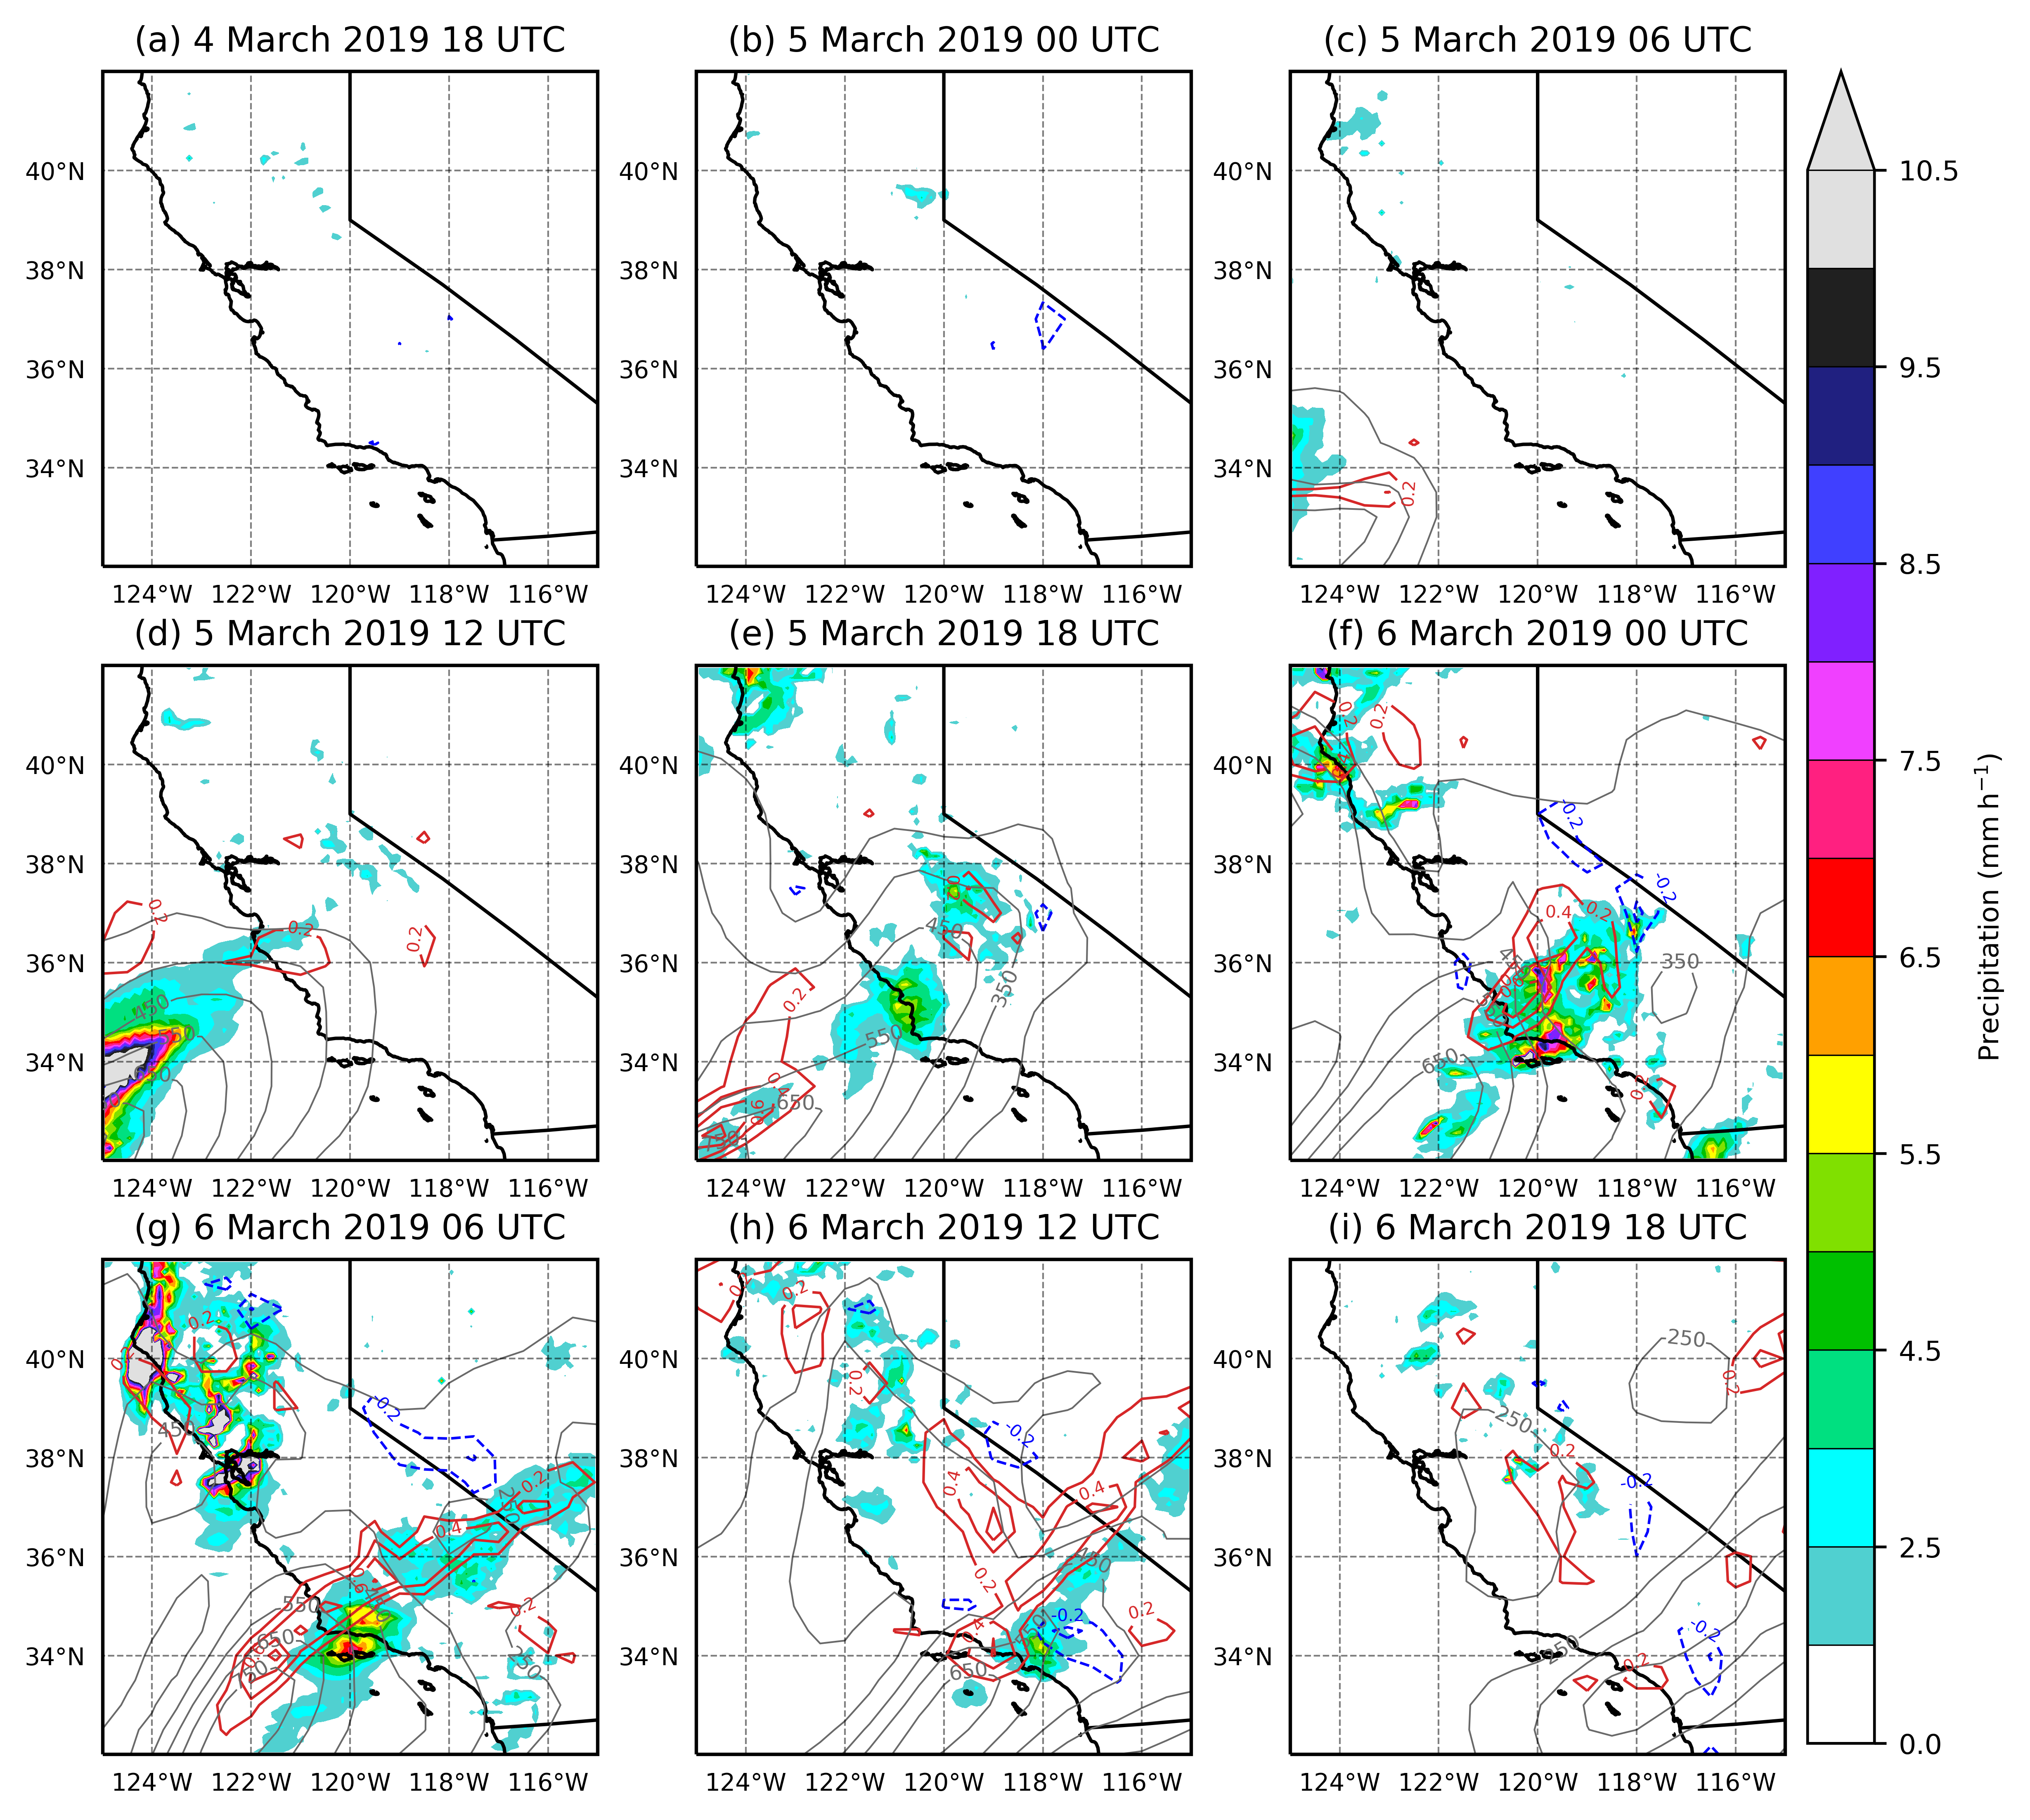

<Figure size 5400x5400 with 0 Axes>

In [8]:
fig = plt.figure(figsize=(9,9))
fig.dpi = 600
fname = './figures/fS2'
fmt1 = 'png'
fmt2 = 'pdf'

# Set up projection
mapcrs = ccrs.PlateCarree()
datacrs = ccrs.PlateCarree()

# Create a feature for States/Admin 1 regions at 1:50m from Natural Earth
states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='50m',
    facecolor='none')

results_gpm = gpm_6hour.values
results_vvel = vvel_ds.vvel.values
subtitles = ['(a) 4 March 2019 18 UTC', 
             '(b) 5 March 2019 00 UTC', '(c) 5 March 2019 06 UTC', '(d) 5 March 2019 12 UTC',
             '(e) 5 March 2019 18 UTC',
            '(f) 6 March 2019 00 UTC', '(g) 6 March 2019 06 UTC', '(h) 6 March 2019 12 UTC',
             '(i) 6 March 2019 18 UTC']

ext = [-115.0, -125.0, 32.0, 42.0]

for i in np.arange(len(results_gpm)):
    ax = plt.subplot(3, 3, i+1, projection=mapcrs)
    ax.set_extent(ext, crs=mapcrs)
    
    # Plot GPM
    cf = ax.contourf(gpm_lons, gpm_lats, results_gpm[i], transform=datacrs,
                     extend='max',
                     cmap=cmap, norm=norm, levels=clevs)
     
    
    # Plot VVEL with multiple linestyle (positive-solid; negative-dashed)
    vvel_sm = gaussian_filter(results_vvel[i], sigma=0.25)
    clevv = (np.arange(-1.0, 0, 0.2),
             np.arange(0.2, 1.2, 0.2))
    linestyles = ('dashed', 'solid')
    colors = ('b', 'tab:red')
    kw_clabels = {'fontsize': 5, 'inline': True, 'inline_spacing': 5, 'fmt': '%.1f',
                  'rightside_up': True, 'use_clabeltext': True}
    for clevvel, linestyle, color in zip(clevv, linestyles, colors):
        cs = ax.contour(vvel_ds.lon, vvel_ds.lat, vvel_sm, levels=clevvel, colors=color,
                        linewidths=0.75, linestyles=linestyle, transform=datacrs)
        plt.clabel(cs, **kw_clabels)
    
    # Plot IVT contours
    ivtclevs = np.arange(250,1150,100)
    ivt_sm = gaussian_filter(ivt_total[i], sigma=0.75)
    cs = ax.contour(ivt_lon, ivt_lat, ivt_sm, ivtclevs, colors='dimgrey', linewidths=0.5,
                      linestyles='solid', transform=datacrs)
    kw_clabels = {'fontsize': 6, 'inline': True, 'inline_spacing': 5, 'fmt': '%i',
                  'rightside_up': True, 'use_clabeltext': True}
    plt.clabel(cs, **kw_clabels)
    
    # Add Border Features
    ax.coastlines(linewidths=1.0, resolution='10m')
    ax.add_feature(states_provinces, edgecolor='k')
    ax.add_feature(cfeature.BORDERS)
    
    ax.set_title(subtitles[i], fontsize=10)
    ## Add in meridian and parallels
    gl = ax.gridlines(crs=mapcrs, draw_labels=True,
                  linewidth=.5, color='black', alpha=0.5, linestyle='--')
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xlocator = mticker.FixedLocator(np.arange(-126., -112., 2))
    gl.ylocator = mticker.FixedLocator(np.arange(30, 44, 2))
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 7}
    gl.ylabel_style = {'size': 7}

# # add colorbar [left, bottom, width, height]
ax2 = fig.add_axes([0.9, 0.13, 0.03, 0.75])
cbar = fig.colorbar(cf, cax=ax2, drawedges=True, 
                    orientation='vertical', extendfrac='auto', extend='max')
cbar.ax.tick_params(labelsize=8)
cbar.set_label('Precipitation $\mathrm{(mm \: h^{-1})}$', fontsize=8)

plt.subplots_adjust(hspace=0.2, wspace=0.1)

fig.savefig('%s.%s' %(fname, fmt1), bbox_inches='tight', dpi=fig.dpi)
fig.savefig('%s.%s' %(fname, fmt2), bbox_inches='tight', dpi=fig.dpi)
fig.clf()


plotFile = fname + '.png'
print(plotFile)
display(Image(plotFile))